Influenza 1918


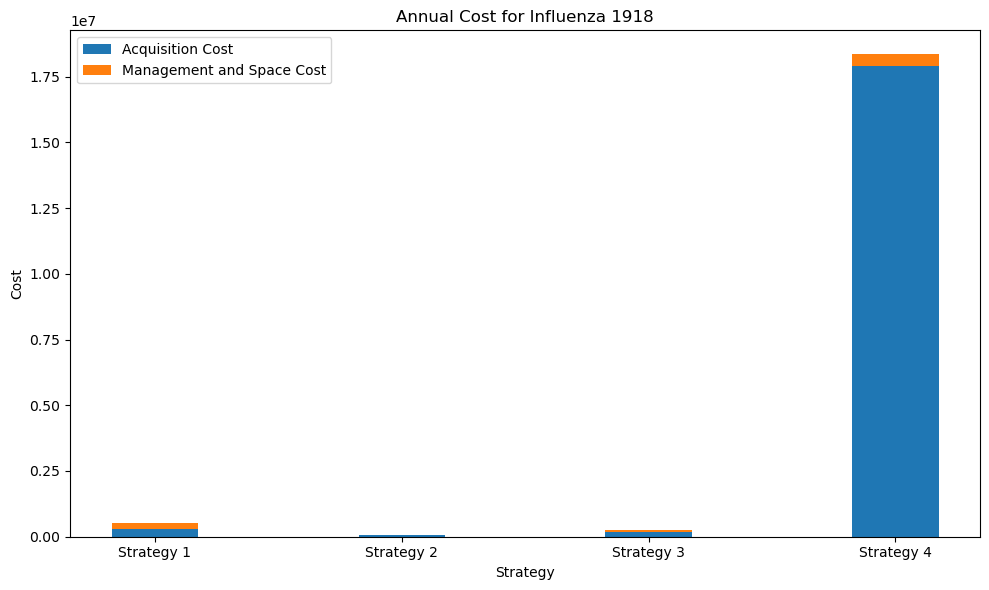

Influenza 1968


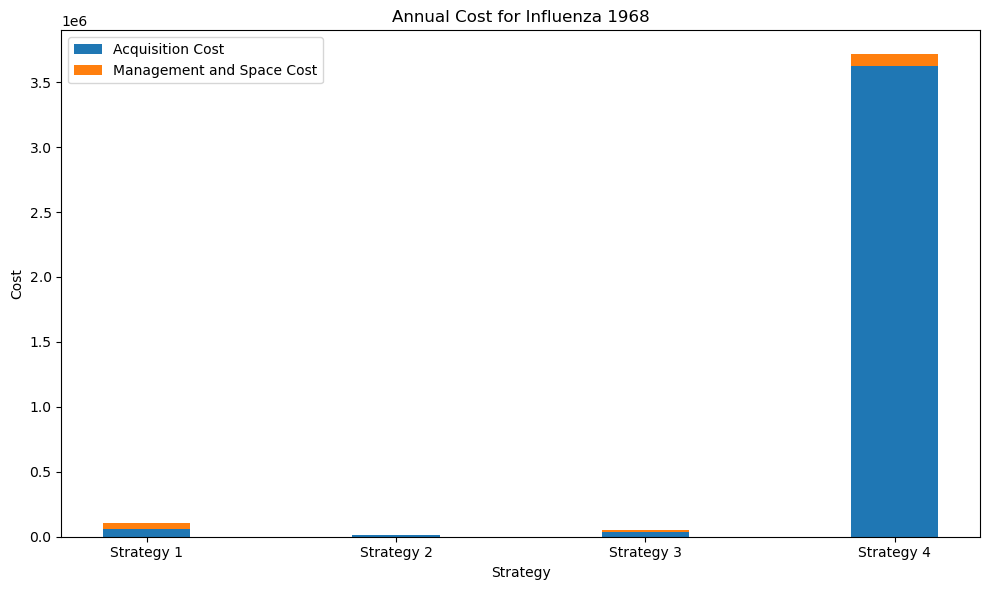

In [13]:
from dataclasses import dataclass, field
from typing import Dict, List, Tuple
import math
import matplotlib.pyplot as plt
import numpy as np





@dataclass(frozen=True)
class Box:
    items_per_box: int
    len: float
    wid: float
    dep: float

    def volume(self) -> float:
        return self.len * self.wid * self.dep


    def fit_inside(self, other_box: 'Box') -> int:
        """
        Calculates how many of the current box can fit inside another box.

        :param other_box: The box inside which to fit
        :return: The number of times the current box fits inside the other box
        """
        return math.ceil(other_box.volume() / self.volume())

    


@dataclass(frozen=True)
class Item:
    name: str
    single_price: float
    box: Box
    shelf_life_in_years: int = 5
    accessories: List[Tuple["Item", float]] = field(default_factory=list)
    """the accessories integer should be retrievable"""

    def total_price(self) -> float:
        subprices = [
            accessory.total_price() * amount_needed
            for accessory, amount_needed in self.accessories
        ]
        all_prices = subprices + [self.single_price]
        return sum(all_prices)

    def items_per_pallet(self, pallet: Box) -> int:
        """Calculate how many items can be stored in a pallet"""
        boxes_per_pallet = self.box.fit_inside(pallet)
        return boxes_per_pallet * self.box.items_per_box

    def total_pallets_needed(self, pallet: Box, quantity: int) -> int:
        subpallets = [
            accessory.total_pallets_needed(pallet, amount_needed * quantity)
            for accessory, amount_needed in self.accessories
        ]
        all_pallets = subpallets + [math.ceil(quantity / self.items_per_pallet(pallet))]
        return sum(all_pallets)


@dataclass(frozen=True)
class Pandemic:
    name: str
    duration_in_weeks: float
    infected_per_population: float
    seek_healthcare_per_infected: float
    hospitalised_per_seek_healthcare: float
    icu_case_per_hospitalised: float
    ventilated_per_icu_case: float
    fatality: float
    average_days_in_hospital_not_icu: float
    average_days_in_hospital_icu: float

    def infected_total(self, population: int) -> float:
        return self.infected_per_population * population

    def seek_healthcare_total(self, population: int) -> float:
        return self.seek_healthcare_per_infected * self.infected_total(population)

    def hospitalised_total(self, population: int) -> float:
        return self.hospitalised_per_seek_healthcare * self.seek_healthcare_total(
            population
        )

    def icu_cases_total(self, population: int) -> float:
        return self.icu_case_per_hospitalised * self.hospitalised_total(population)

    def ventilated_total(self, population: int) -> float:
        return self.ventilated_per_icu_case * self.icu_cases_total(population)

    def deaths(self, population: int) -> float:
        return self.fatality * self.infected_total(population)

    def outpatient_visits(self, population: int) -> float:
        return self.seek_healthcare_total(population) - self.hospitalised_total(
            population
        )

    def non_icu_patient_days(self, population: int) -> float:
        return (
            self.hospitalised_total(population) * self.average_days_in_hospital_not_icu
        )

    def non_mv_icu_patient_days(self, population: int) -> float:
        return (
            self.icu_cases_total(population)
            * (1 - self.ventilated_per_icu_case)
            * self.average_days_in_hospital_icu
        )

    def mv_icu_patient_days(self, population: int) -> float:
        return self.ventilated_total(population) * self.average_days_in_hospital_icu

    def dictionary_of_contacts(
        self, professions: List["Profession"], population: int
    ) -> Dict[str, int]:
        return {
            item.name: item.total_contacts(self, population) for item in professions
        }

    def dict_profession_to_total_hcw_involved(self, professions: List["Profession"], population: int) -> Dict[str,float]:
        return{profession.name: profession.total_contacts(self, population)/(profession.contacts_per_week*self.duration_in_weeks* (1-profession.attrition_rate)) for profession in professions}
  
    
    """
    I want to replace the following lines of code further down below with a function here
        mds_involved = md.number_of_profession_involved_in_pandemic(influenza1918, 1000000)
    rns_involved = rn.number_of_profession_involved_in_pandemic(influenza1918, 1000000)


    def number_of_specific_profession_involved(self, population: int, profession: "Profession") -> float:
        return profession.total_contacts(self, population:int)/ (profession.contacts_per_week * self.duration_in_weeks * (1 - profession.attrition_rate))
    """    

    



@dataclass(frozen=True)
class Profession:
    name: str
    contacts_per_hospitalised: int = 0
    """0 for Other HCW, only input for Escort"""
    contacts_per_outpatient_visit: int = 0
    """0 for resp tech, radio tech, housekeepers"""
    contacts_per_non_icu_patient_day: int = 0
    """0 for administrative, only input for phlebotomists"""
    contacts_per_icu_patient_day: int = 0
    """0 for administrative"""
    contacts_per_mv_day: int = 0
    """0 for administrative"""
    contacts_per_week: float = 80.0
    """assuming 40 work hours and 2 contacts per hour"""
    attrition_rate: float = 0.4

    def total_contacts(self, pandemic: Pandemic, population: int) -> int:
        return (
            pandemic.hospitalised_total(population) * self.contacts_per_hospitalised
            + pandemic.outpatient_visits(population)
            * self.contacts_per_outpatient_visit
            + pandemic.non_icu_patient_days(population)
            * self.contacts_per_non_icu_patient_day
            + pandemic.non_mv_icu_patient_days(population)
            * self.contacts_per_icu_patient_day
            + pandemic.mv_icu_patient_days(population) * self.contacts_per_mv_day
        )

    def number_of_profession_involved_in_pandemic(
        self, pandemic: Pandemic, population: int
    ) -> float:
        return self.total_contacts(pandemic, population) / (
            self.contacts_per_week
            * pandemic.duration_in_weeks
            * (1 - self.attrition_rate)
        )


@dataclass
class Strategy:
    name: str
    respirator_amounts: List[Tuple["Item", int]] = field(default_factory=list)

    def acquisition_cost_of_respirators(self) -> float: 
        subprices = [item.total_price() * amount for item, amount in self.respirator_amounts]
        return sum(subprices)
    """I divert from the original model in allowing different shelf lives for different items. I
    calculate the prorated annual acquisition cost first, and then multiply by stockpile duration.
    As it is now, the model will input 5 years of shelf life and a 5 year stockpile, and I didn't
    """
    def prorated_annual_acquisition_cost(self) -> float:
        subprices_prorated = [
            (item.total_price() * amount) / item.shelf_life_in_years
            for item, amount in self.respirator_amounts
        ]
        return sum(subprices_prorated)

@dataclass
class Warehouse:
    lease_price_per_sqm: float
    utility_cost_per_sqm: float
    salary_per_ftee: float
    management_coverage_sqm: float
    pallet: Box
    aisle_space_ratio: float = 0.20
    stacked_pallets: int = 2

    def calculate_pallets_needed(self, strategy: Strategy) -> int:
        return sum(item.total_pallets_needed(self.pallet, quantity) for item, quantity in strategy.respirator_amounts)

    def pallets_footprint(self, num_pallets: int) -> float:
        """Calculate the footprint of a certain number of pallets in sq m."""
        return num_pallets * self.pallet.len * self.pallet.wid / self.stacked_pallets

    def total_space_needed(self, num_pallets: int) -> float:
        """Calculate total space needed for a certain number of pallets in sq m, considering aisle space."""
        return self.pallets_footprint(num_pallets) * (1 + self.aisle_space_ratio)

    def space_cost_per_year(self, num_pallets: int) -> float:
        """Calculate the annual cost for the space needed for a certain number of pallets."""
        return self.total_space_needed(num_pallets) * (self.lease_price_per_sqm + self.utility_cost_per_sqm)

    def management_cost_per_year(self, num_pallets: int) -> float:
        """Calculate the annual cost for the management needed for a certain number of pallets."""
        sqm_covered_per_ftee = self.management_coverage_sqm
        ftees_needed = self.total_space_needed(num_pallets) / sqm_covered_per_ftee
        return ftees_needed * self.salary_per_ftee

    def total_cost_per_year(self, num_pallets: int) -> float:
        """Calculate the total annual cost (space and management) for a certain number of pallets."""
        return self.space_cost_per_year(num_pallets) + self.management_cost_per_year(num_pallets)


if __name__ == "__main__":
    influenza1918 = Pandemic(
        name="Influenza 1918",
        duration_in_weeks=12.0,
        infected_per_population=0.3,
        seek_healthcare_per_infected=0.5,
        hospitalised_per_seek_healthcare=0.22,
        icu_case_per_hospitalised=0.15,
        ventilated_per_icu_case=0.5,
        fatality=0.021,
        average_days_in_hospital_not_icu=5,
        average_days_in_hospital_icu=10,
    )

    influenza1968 = Pandemic(
        name="Influenza 1968",
        duration_in_weeks=12.0,
        infected_per_population=0.3,
        seek_healthcare_per_infected=0.5,
        hospitalised_per_seek_healthcare=0.02,
        icu_case_per_hospitalised=0.15,
        ventilated_per_icu_case=0.5,
        fatality=0.0023,
        average_days_in_hospital_not_icu=5,
        average_days_in_hospital_icu=10,
    )


    md = Profession(
        name="MD",
        contacts_per_hospitalised=3,
        contacts_per_outpatient_visit=1,
        contacts_per_non_icu_patient_day=2,
        contacts_per_icu_patient_day=4,
        contacts_per_mv_day=4,
    )

    rn = Profession(
        name="RN",
        contacts_per_hospitalised=5,
        contacts_per_outpatient_visit=2,
        contacts_per_non_icu_patient_day=6,
        contacts_per_icu_patient_day=24,
        contacts_per_mv_day=24,
    )

    resp_tech = Profession(
        name="Respiratory tech",
        contacts_per_hospitalised=3,
        contacts_per_outpatient_visit=0,
        contacts_per_non_icu_patient_day=6,
        contacts_per_icu_patient_day=12,
        contacts_per_mv_day=6,
    )

    radiology_tech = Profession(
        name="Radiology tech",
        contacts_per_hospitalised=1,
        contacts_per_outpatient_visit=0,
        contacts_per_non_icu_patient_day=1,
        contacts_per_icu_patient_day=2,
        contacts_per_mv_day=2,
    )
    phlebotomists = Profession(name="Phlebotomists", contacts_per_non_icu_patient_day=1)

    housekeepers = Profession(
        name="Housekeepers",
        contacts_per_hospitalised=1,
        contacts_per_outpatient_visit=0,
        contacts_per_non_icu_patient_day=1,
        contacts_per_icu_patient_day=1,
        contacts_per_mv_day=1,
    )

    other_hcw = Profession(
        name="Other HCW",
        contacts_per_hospitalised=0,
        contacts_per_outpatient_visit=1,
        contacts_per_non_icu_patient_day=1,
        contacts_per_icu_patient_day=1,
        contacts_per_mv_day=1,
    )
    administrative = Profession(
        name="Administrative",
        contacts_per_hospitalised=2,
        contacts_per_outpatient_visit=1,
    )

    escort = Profession(name="Escort", contacts_per_hospitalised=1)

    professions = [
        md,
        rn,
        resp_tech,
        radiology_tech,
        phlebotomists,
        housekeepers,
        other_hcw,
        administrative,
        escort,
    ]


    """the following function is a workaround with the number 115, and I couldnt place the comment in the place I wanted to.
    number of batteries in the baracco model is Total Contacts (of all HCW)/20"""

    papr = Item(
        name="PAPR",
        single_price=500.0,
        box=Box(items_per_box=1, len=0.508, wid=0.406, dep=0.254),
        accessories=[
            (
                Item(
                    name="Filter set",
                    single_price=27.13,
                    box=Box(items_per_box=3, len=0.229, wid=0.229, dep=0.152),
                    accessories=[],
                ),
                3,
            ),
            
            (
                Item(
                    name="Battery",
                    single_price=286.0,
                    box=Box(1, 0.254, 0.254, 0.229),
                    accessories=[],
                ),
                115.2,

            ),
            (Item("Hood", 30.87, Box(3, 0.229, 0.229, 0.229)), 3),
            (Item("Tube", 30.89, Box(5, 0.508, 0.406, 0.254)), 3),
        ],
    )
    elastomeric = Item(
        name="Elastomeric",
        single_price=25.0,
        box=Box(items_per_box=10, len=0.178, wid=0.33, dep=0.457),
        accessories=[
            (
                Item(
                    name="E Filter set",
                    single_price=2.5,
                    box=Box(1, 0.135, 0.13, 0.036),
                    accessories=[],
                ),
                3,
            )
        ],
    )
    n95 = Item(
        name="N95",
        single_price=0.25,
        box=Box(items_per_box=20, len=0.305, wid=0.152, dep=0.152),
        accessories=[],
        shelf_life_in_years=5
    )

pallet = Box(items_per_box=1, len=1.2192, wid=1.016, dep=1.2192)  # dimensions in meters
warehouse = Warehouse(
    lease_price_per_sqm=75.347,
    utility_cost_per_sqm=32.292,
    salary_per_ftee=80000,
    management_coverage_sqm=929.03,
    pallet=pallet
)

def plot_costs(scenario, strategies):
    plt.figure(figsize=(10, 6))
    plt.title(f"Annual Cost for {scenario.name}")

    bar_width = 0.35
    acquisition_costs = [s.annual_acquisition_cost for s in strategies]
    space_and_mgmt_costs = [s.annual_management_and_space_cost for s in strategies]
    
    index = np.arange(len(strategies))
    
    plt.bar(index, acquisition_costs, bar_width, label="Acquisition Cost")
    plt.bar(index, space_and_mgmt_costs, bar_width, bottom=acquisition_costs, label="Management and Space Cost")

    plt.xlabel('Strategy')
    plt.ylabel('Cost')
    plt.xticks(index, [s.name for s in strategies])
    plt.legend()

    plt.tight_layout()
    plt.show()




stockpile_duration_in_years = 5

scenarios = [influenza1918,influenza1968]
POPULATION = 1000000

for scenario in scenarios:
    contacts = scenario.dictionary_of_contacts(professions, POPULATION)
    total_hcw_involved = sum(scenario.dict_profession_to_total_hcw_involved(professions, POPULATION).values())
    mds_involved = md.number_of_profession_involved_in_pandemic(scenario, POPULATION)
    rns_involved = rn.number_of_profession_involved_in_pandemic(scenario, POPULATION)
    print(scenario.name)

    strategies = [
        Strategy("Strategy 1", [(n95, sum(contacts.values())), (elastomeric, 0), (papr, 0)]),
        Strategy("Strategy 2", [(n95,0), (elastomeric, total_hcw_involved),(papr,0)]),
        Strategy("Strategy 3", [(n95,(sum(contacts.values())-contacts['MD']-contacts['RN'])),(elastomeric, (rns_involved + mds_involved)),(papr,0)]),
        Strategy("Strategy 4", [(n95,0), (elastomeric,0),(papr,(total_hcw_involved/(3+1)))])
    ]

    for strategy in strategies:
        num_pallets = warehouse.calculate_pallets_needed(strategy)
        annual_acquisition_cost = strategy.prorated_annual_acquisition_cost()
        annual_management_and_space_cost = warehouse.total_cost_per_year(num_pallets)

        # Save these as temporary attributes on the Strategy object.
        strategy.annual_acquisition_cost = annual_acquisition_cost
        strategy.annual_management_and_space_cost = annual_management_and_space_cost

    plot_costs(scenario, strategies)




    
#june 24, line 351: included new dictionary that offers attrition rate

#print(papr.total_price(),elastomeric.total_price(),n95.total_price())
# print(influenza1918.outpatient_visits(1000000))
# print(sum(contacts.values()))
# print(influenza1918.dictionary_of_contacts(professions, 1000000))
# print(total_hcw_involved)
# print(mds_involved)
# print(rns_involved)
# print(strategy3.acquisition_cost_of_respirators(),strategy3.prorated_annual_acquisition_cost())

#print(strategy4.acquisition_cost_of_respirators(),strategy4.prorated_annual_acquisition_cost())